# Algoritmo K-Medias
Primero descargaremos la base de datos de iris, únicamente para esto usaremos sklearn que tiene el repositorio online sin necesidad de descargar un CSV. De ahí en fuera, no lo usaremos más.

In [1]:
from sklearn import datasets 
iris = datasets.load_iris()

Ahora transformaremos esta base de datos en un Data Frame de Pandas poder trabajar fácilmente

In [2]:
import pandas as pd
iris=pd.DataFrame(iris.data)
iris.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Estableceremos una variable K=3 para trabajar únicamente con esta cantidad de categorías para este ajuste.

In [3]:
K=3

Definiremos algunos valores aleatorios iniciales para estos grupos μk. Veamos primero el rango de cada dimensión para encontrar los límites de cada μk

In [5]:
import numpy as np #Calcular máximo y mínimo 

In [6]:
zero_min=np.min(iris.loc[:,0])
zero_max=np.max(iris.loc[:,0])

one_min=np.min(iris.loc[:,1])
one_max=np.max(iris.loc[:,1])

two_min=np.min(iris.loc[:,2])
two_max=np.max(iris.loc[:,2])

three_min=np.min(iris.loc[:,3])
three_max=np.max(iris.loc[:,3])

La base de datos tiene información fraccionaria y para generar los números aleatorios correspondientes es necesarios volverlos enteros. Esto lo hacemos para que sea más fácil trabajar con numpy

In [7]:
print(int(zero_min*10),int(zero_max*10))

43 79


In [8]:
zero_min=int(zero_min*10)
zero_max=int(zero_max*10)

one_min=int(one_min*10)
one_max=int(one_max*10)

two_min=int(two_min*10)
two_max=int(two_max*10)

three_min=int(three_min*10)
three_max=int(three_max*10)

Ahora tenemos todos los límites para cada dimensión en el conjunto de datos. Luego, podemos establecer los valores iniciales para μk, vamos a insertar todos estos valores en un nuevo vector llamado mu

In [9]:
np.random.seed(1500) #Definir una semilla aleatoria para tener los mismos resultados que yo

In [10]:

mu=[]
for i in range(0,K):
    zeros=np.random.randint(zero_min,zero_max)
    ones=np.random.randint(one_min,one_max)
    twos=np.random.randint(two_min,two_max)
    threes=np.random.randint(three_min,three_max)
    
    mu.append([zeros,ones,twos,threes])

Luego, vamos a transformar centros en una matriz numpy y dividir por 10 para tener μk para tener los valores correctos para el conjunto de datos.

In [11]:
mu=np.array(mu)/10
mu

array([[6.2, 3.1, 1.1, 1.5],
       [4.5, 2.9, 2.5, 2. ],
       [5.9, 3. , 2.7, 0.8]])

Será necesario crear una matriz para agregar $ k $ columnas. Los llamaremos $ r_ {n, k} $. Donde $ n $ es una única observación de conjunto de datos y $ k $ corresponde a cada grupo definido. Considere $r_{n,k}\in\{0,1\}$

Esto debería verse como:

In [12]:
r=np.zeros(iris.shape[0]*K).reshape(iris.shape[0],K)
pd.DataFrame(r).head()

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


¿Cómo funciona el algoritmo?
Ahora, el paso complejo, o tal vez no. Vamos a definir una función $ J $, esta se llamará como medida de distorsión y viene dada por:

$$
J=\sum_{n=1}^{N}\sum_{k=1}^{K}r_{n,k}||x_{n}-\mu_{k}
||^2
$$
Donde $ N $ es el número total de observaciones en el conjunto de datos, $ K $ es el total de conglomerados definidos, $ x_n $ es cada observación y sabemos qué significa $ \mu_k $ y $ r_ {n, k} $. Como podemos ver, todo el conjunto de datos se usará para encontrar el vector centroide dado por $ \mu_k $. Existe otra forma de estimar los mejores centroides mediante el procedimiento de Robbins-Monro, aplicando un algoritmo estocástico en línea, pero será en otro momento.

I. Nuestro primer objetivo es minimizar $ J $ con respecto a $ r_ {n, k} $, manteniendo $ \mu_k $ fijo. Y considerando la siguiente regla:

$$ r_ {n, k} = \ begin {cases} 1, & \ text {if $ k = argmin_j || x_ {n} - \mu_ {j} || ^ 2 $}. \\ 0, & \ texto {de lo contrario}. \ end {cases} $$
II. Luego, vamos a minimizar nuevamente $ J $, pero con respecto a $ \mu_k $, manteniendo $ r_ {n, k} $ fijo. Considere la siguiente fórmula:

$$
\mu_k=\frac{\sum_n r_{n,k} x_n}{\sum_n r_{n,k}}
$$
Realizaremos los pasos anteriores hasta la convergencia.

In [14]:
plot_counter=0
J_plot=[]
for i in range(1,10): #Para este caso solo queremos como máximo 10 iteraciones
    J=0 #Inicializando la medida de distorsión
    
    # Este ciclo será para crear todos los valores para r_ {n, k} usando la base de datos
    for n in range(0,iris.shape[0]): 
        x=np.array(iris.iloc[n,0:4])
        mins=[]

        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k])# Usando la distancia euclidiana con numpy
            mins.append(distance**2) #Simplemente agregue todas las distancias en los nuevos minutos del vector, este vector solo los mantiene

        k_r=np.argmin(np.array(mins))#Aplicamos la REGLA I
        r[n,k_r]=1 #Para el caso contrario, al final inicializamos nuevamente el ciclo para que tenga un vector de ceros.
    
    #Las siguientes líneas calcularán la medida de distorsión y mantendrán el valor de J para la gráfica.
    for n in range(0,iris.shape[0]):
        for k in range(0,K):
            distance=np.linalg.norm(x-mu[k])
            J=r[n,k]*(distance**2)+J
    J_plot.append(J)
    
#Ahora, vamos a actualizar los centroides con todos los mu usando II. Por eso es un algoritmo K-Means
    for k in range(0,K):
        count_1,count_2=0,0
        for n in range(0,iris.shape[0]):
            x=np.array(iris.iloc[n,0:4])
            count_1=r[n,k]*x+count_1
            count_2=r[n,k]+count_2
        mu[k]=count_1/count_2
        
    print(J)
    #Esta simple regla es solo para romper el ciclo si la J anterior y la J real no cambian considerablemente
    if i>1 and abs(J-J_prev)<0.5:
        break
    J_prev=J
    plot_counter=1+plot_counter
    #Como dije antes, esto reinicializa el vector r con ceros
    r=np.zeros(iris.shape[0]*K).reshape(iris.shape[0],K)

1100.879999999999
1077.8460571113644
870.987494853379
869.126836320042
923.8112637226989
925.4275481881676
925.7231759999969


Ahora vamos a llamar a matplotlib para ver cómo se actualiza la J y la medida de distorsión disminuye.

In [15]:
import matplotlib.pyplot as plt

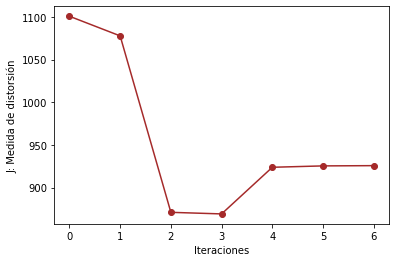

In [30]:
plt.plot(J_plot,linestyle='-', marker='o',color='brown')
plt.ylabel('J: Medida de distorsión')
plt.xlabel('Iteraciones')
plt.show()

Como vimos, la convergencia de J está asegurada, pero es más común converger a un mínimo local que a uno global para J. Esto fue estudiado por MacQueen (1967). El vector final para todos los centroides o mu será:

In [18]:
mu

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.82962963, 2.73148148, 4.31481481, 1.39259259],
       [6.76956522, 3.03695652, 5.6       , 2.00869565]])

### Inicialización

Así se ve el conjunto de datos si solo graficamos las características 0 y 1

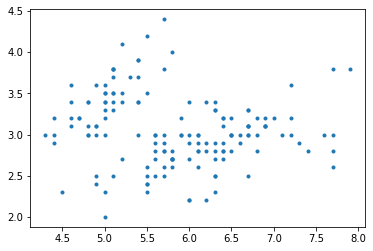

In [19]:
plt.scatter(iris[0],iris[1],marker='.')
plt.show()

### Asignación de Objetos

Si sumamos los centroides $\mu$ al diagrama de dispersión veremos dónde están las zonas principales de cada categoría K

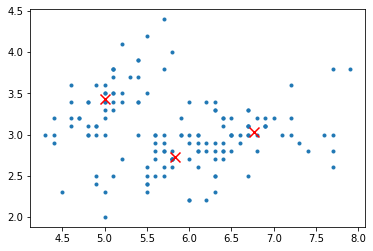

In [23]:
mu=pd.DataFrame(mu)
plt.scatter(iris[0],iris[1],marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.show()

### Actualización Centroides

Ahora queremos saber qué punto pertenece a cada una de las categorías $ K = 3 $. Necesitamos calcular la distancia de cada punto a cada centroide $ \mu $ e identificar el más cercano. Esta información ya existe en el vector $ r_ {n, k} $ después del ajuste. Si hay una nueva observación, simplemente calcule las distancias del nuevo $ x_i $ con $ \mu_k $ para $ k = 1,2,3 $ en este caso.

In [24]:
r_new=[]
for row in r:
    r_new.append(np.argmax(row)+1)
iris[4]=r_new

Después de crear un nuevo vector solo para establecer las etiquetas correctas, simplemente trazamos cada categoría. La marca $"x"$ muestra el centroide y el área coloreada al lado es la categoría.

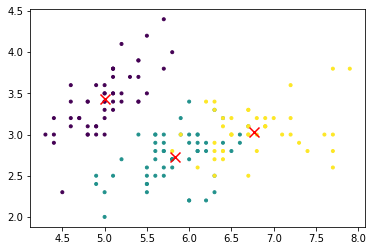

In [25]:
plt.scatter(iris[0],iris[1],c=iris[4],marker='.')
plt.scatter(mu[0],mu[1],s=100,marker='x',color='red')
plt.show()

Parece que el algoritmo no clasifica los puntos más cercanos como parte de una categoría $ \mu_k $. Recuerde que solo estamos trazando en 2D, el conjunto de datos completo pertenece a 4D y estamos usando la distancia euclidiana. Desafortunadamente, podemos ver mucho en 3D.

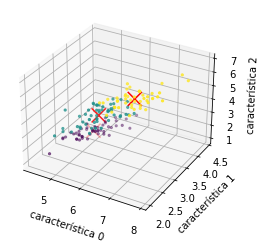

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 =iris[0]
y1 =iris[1]
z1 =iris[2]

x2=mu[0]
y2=mu[1]
z2=mu[2]

ax.scatter(x1, y1, z1, c=iris[4], marker='.')
ax.scatter(x2, y2, z2, c='red', s=200, marker='x')

ax.set_xlabel('característica 0')
ax.set_ylabel('característica 1')
ax.set_zlabel('característica 2')

plt.show()